# Intro

## What have we learned so far?

We are given a random sample $X_1, X_2, ..., X_n$ from the distribution $F$ (with density $f$).

* If we know that $f$ is from a specific parametric family
  * We can try to estimate its parameters. How can we do that?
    1. Method of moments
    2. Maximum likelihood
  * What can we say about uncertainty in our estimates?
    1. Exact distribution of the estimator is known -> use exact confidence interval
    2. Asymptotic normality of MLE -> approximate confidence interval, holds for large sample sizes
    3. Bootstrap
  * More complicated function
    * Use functional invariance of MLE

# Confidence intervals and bootstrap

In [4]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
cmap = plt.get_cmap("tab10")

#%matplotlib widget

np.random.seed(31337)

from plot_dist import plot_est_hist_normal, plot_empirical_cdf
from parallel import run_parallel
from emp_dist import EmpiricalDistribution

## Confidence interval for the mean of exponential distribution

We would like to estimate the mean of the exponential distribution: 
$$
f(x;\lambda) = \left\{
    \begin{array}\\
        \lambda e^{-\lambda x} & \mbox{if } \ x \ge 0, \\
        0 & \mbox{if } \ x < 0
    \end{array}
\right.
$$

If $X \sim Exp(\lambda)$, then $m = E[X] = \frac{1}{\lambda}$.

### Derive MLE

$$\mathcal{L}_n(\lambda)= \prod_{i=1}^{n} \lambda e^{\lambda X_i} = \lambda^n e^{-\lambda \sum_{i=1}^{n} X_i}$$
$$\ln \mathcal{L}_n(\lambda) = n \ln \lambda - \lambda \sum_{i=1}^{n} X_i$$
$$\partial_{\lambda} \ln \mathcal{L}_n(\lambda) = \frac{n}{\lambda} - \sum_{i=1}^{n} X_i$$
$$\partial_{\lambda} \ln \mathcal{L}_n(\lambda) = 0 \implies \widehat{\lambda}_{MLE} = \frac{1}{n} \sum_{i=1}^{n} X_i$$

Maximum likelihood estimate is: $\widehat{m}_{MLE} = \frac{1}{\widehat{\lambda}_{MLE}}=\overline{X}=\frac{1}{n}\sum_{i=1}^{n} X_i$

### Derive exact interval

To derive properties of the sampling distribution, we need to find the distribution of $\sum_{i=1}^{n} X_i$. If $Z_n = \sum_{i=1}^{n} X_i$, then $Z_n \sim Erlang(n, \lambda)$, where 
$$
f_{Z_n}(z) = \left\{
    \begin{array}\\
        \frac{\lambda^n x^{n-1} e^{-\lambda z}}{(k-1)!} & \mbox{if } \ z \ge 0, \\
        0 & \mbox{if } \ x < 0
    \end{array}
\right.
$$

*Hint*: if $X, Y$ are two independent random variables with densities $f_X(x), f_Y(y)$, then $f_{X+Y}(t) = \int f_X(t-y) f_Y(y) dy$

Looking at the density we can notice that $2 \lambda \sum_{i=1}^{n} X_i \sim \chi_{2n}^2$. Since Chi-squared distribution is implelemented in many scientific packages, we can esily calculate its quantiles, so:
$$\mathbb{P} \left\{\chi_{1-\frac{\alpha}{2},2n}^2 < 2 \lambda \sum_{i=1}^{n} X_i < \chi_{\frac{\alpha}{2},2n}^2\right\} = 1 - \alpha,$$
$$\mathbb{P} \left\{\frac{2 \sum_{i=1}^{n} X_i}{\chi_{\frac{\alpha}{2},2n}^2} < \frac{1}{\lambda} < \frac{2 \sum_{i=1}^{n} X_i}{\chi_{1-\frac{\alpha}{2},2n}^2}\right\} = 1 - \alpha,$$
$$m \in \left(\frac{2 \sum_{i=1}^{n} X_i}{\chi_{\frac{\alpha}{2},2n}^2}, \frac{2 \sum_{i=1}^{n} X_i}{\chi_{1-\frac{\alpha}{2},2n}^2}\right).$$

We start with a sample from the exponential distribution with known parameters

In [5]:
true_lambda = 3
true_mean = 1 / true_lambda
sample_size = 30

X = np.random.exponential(scale=true_mean, size=sample_size)

(array([2.31544724, 1.54363149, 1.28635958, 0.25727192, 0.25727192,
        1.02908766, 0.51454383, 0.        , 0.25727192, 0.25727192]),
 array([0.01351816, 0.14308277, 0.27264737, 0.40221197, 0.53177657,
        0.66134117, 0.79090578, 0.92047038, 1.05003498, 1.17959958,
        1.30916419]),
 <BarContainer object of 10 artists>)

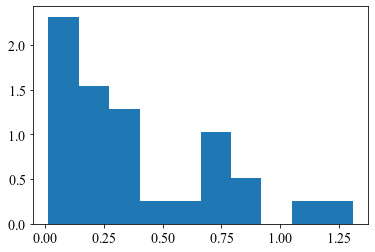

In [6]:
plt.figure()
plt.hist(X, density=True)

Calculate estimate of the mean:

In [7]:
X.mean()

0.3827350281976463

Calculate the 'exact' confidence interval based on Chi-squared distribution:

In [8]:
def exp_exact_interval(X, level=0.95):
    return 2 * X.sum() / scipy.stats.chi2.interval(level, df=2 * len(X))[::-1]

In [9]:
exact_int = exp_exact_interval(X)
exact_int

array([0.27568719, 0.56727051])

Apply non-parametric bootstrap and calculate normal-based confidence intervals:

In [10]:
def boot_estimates(estimator, X, num_resamples=1000):
    estimates = np.empty(num_resamples)
    for i in range(num_resamples):
        estimates[i] = estimator(np.random.choice(X, size=len(X), replace=True))
    return estimates

In [11]:
def normal_interval(estimates, level=0.95):
    alpha = 1 - level
    s_boot = estimates.std()
    z = scipy.stats.norm.ppf(1 - alpha/2)
    m = estimates.mean()
    return m - z * s_boot, m + z * s_boot

In [12]:
def boot_interval(estimates, level=0.95):
    alpha = 1 - level
    m = estimates.mean()
    return 2 * m - np.quantile(estimates, 1 - alpha), 2 * m - np.quantile(estimates, alpha)

In [13]:
normal_interval(boot_estimates(np.mean, X, num_resamples=5000))

(0.2590577589279396, 0.5090510580432617)

In [14]:
boot_interval(boot_estimates(np.mean, X, num_resamples=5000))

(0.27995116790489577, 0.48176422291483295)

Bootstrap interval appers to  quite different from the exact calculation. Let's ivestigate:

In [15]:
print("Statistic: {:.2f}, Interval: [{:.2f}, {:.2f}], Midpoint: {:.2f}".format(
2 * true_lambda * X.sum(), *(lambda x: (*x, np.array(x).mean()))(scipy.stats.chi2.interval(0.95, df=2 * len(X)))))

Statistic: 68.89, Interval: [40.48, 83.30], Midpoint: 61.89


### Compare bootstrap and exact interval on a single sample

We can vary number of bootstrap resamples:

In [16]:
sizes = [10, 20, 30 ,50, 100, 200, 500, 1000, 2000]
norm_ints = np.empty((len(sizes), 2))
boot_ints = np.empty_like(norm_ints)
for i, s in enumerate(sizes):
    norm_ints[i] = normal_interval(boot_estimates(np.mean, X, num_resamples=s))
    boot_ints[i] = boot_interval(boot_estimates(np.mean, X, num_resamples=s))

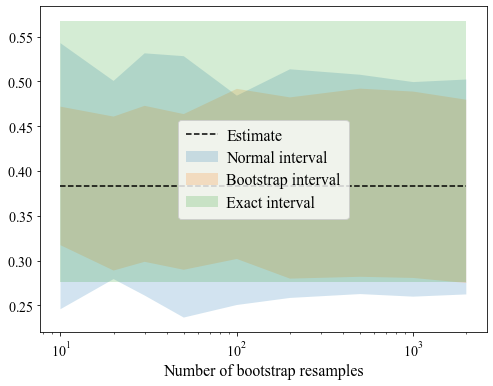

In [17]:
plt.figure(figsize=(8, 6))
plt.fill_between(sizes, norm_ints[:, 0], norm_ints[:, 1], alpha=0.2, label='Normal interval')
plt.fill_between(sizes, boot_ints[:, 0], boot_ints[:, 1], alpha=0.2, label='Bootstrap interval')
plt.fill_between(sizes, [exact_int[0]] * len(sizes), [exact_int[1]] * len(sizes), alpha=0.2, label='Exact interval')
plt.plot(sizes, [X.mean()]*len(sizes), 'k--', label='Estimate')
plt.xscale('log')
plt.xlabel('Number of bootstrap resamples')
plt.legend(loc='center')

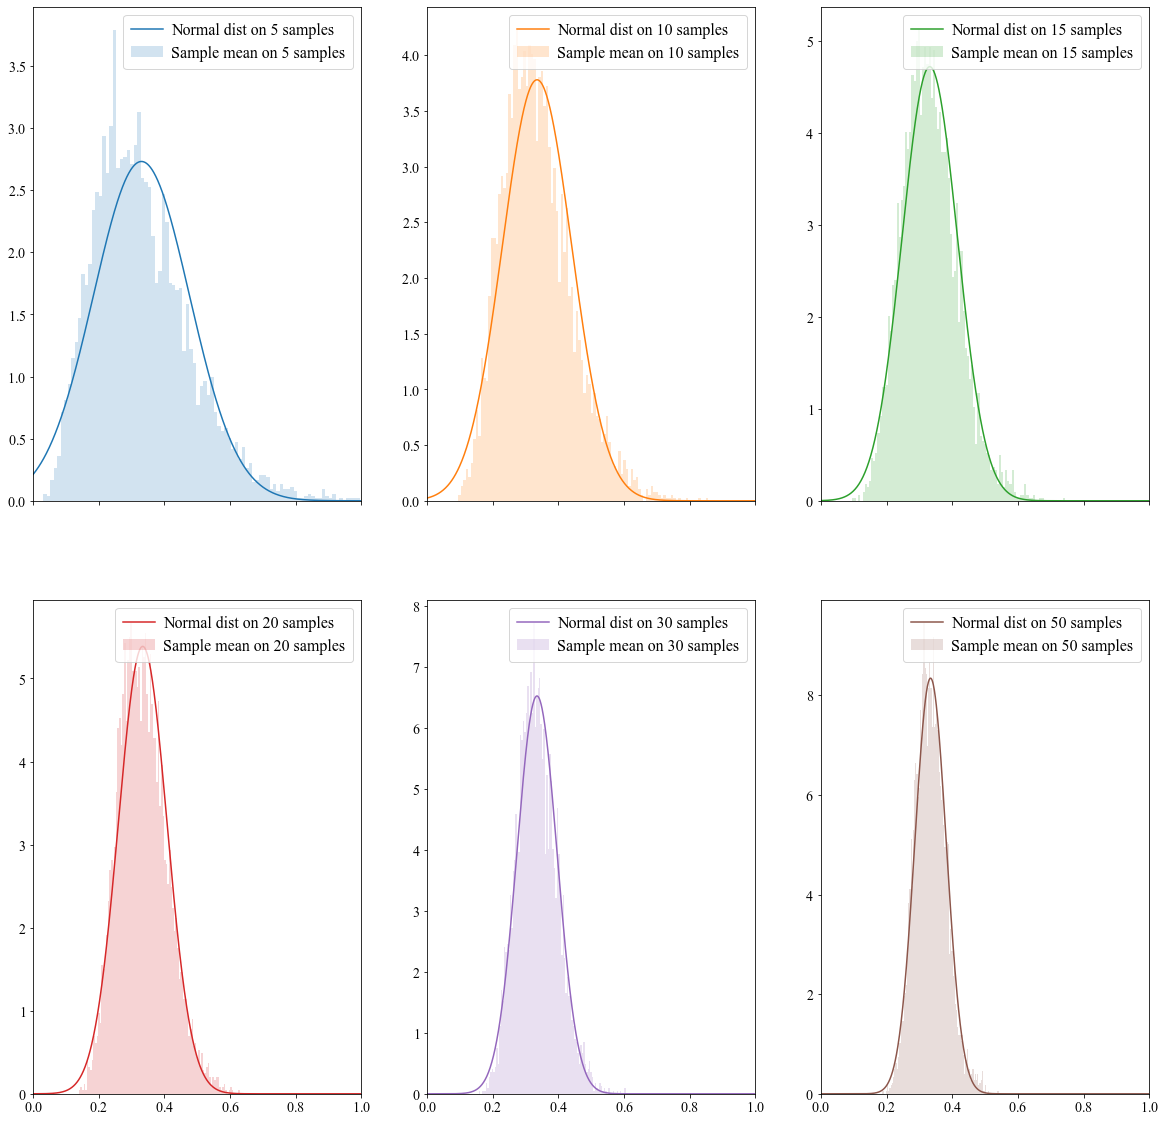

In [18]:
plot_est_hist_normal(error_gen=np.random.exponential, 
                     estimator=lambda x: x.mean(axis=1),
                     name='Sample mean',
                     mu=0,
                     sigma=true_mean,
                     sample_sizes=[5, 10, 15, 20, 30, 50],
                     num_repeats=5000,
                     x_min=0,
                     x_max=1)

In [19]:
sizes = [10, 20, 30 , 50, 100, 200, 500, 1000, 2000]
norm_ints = np.empty((len(sizes), 2))
boot_ints = np.empty_like(norm_ints)
exact_ints = np.empty_like(norm_ints)
estimates = np.empty(len(sizes))
for i, s in enumerate(sizes):
    Xi = np.random.exponential(scale=true_mean, size=s)
    estimates[i] = Xi.mean()
    norm_ints[i] = normal_interval(boot_estimates(np.mean, Xi))
    boot_ints[i] = boot_interval(boot_estimates(np.mean, Xi))
    exact_ints[i] = exp_exact_interval(Xi)

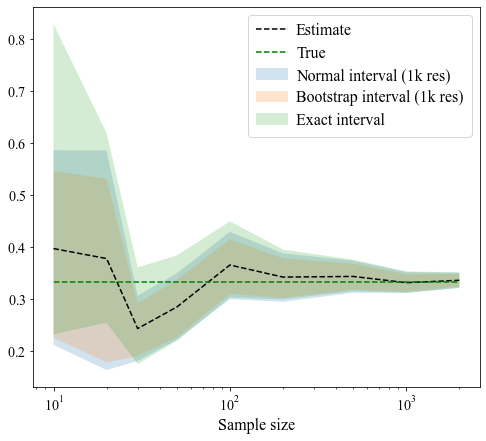

In [20]:
plt.figure(figsize=(8, 7))
plt.fill_between(sizes, norm_ints[:, 0], norm_ints[:, 1], alpha=0.2, label='Normal interval (1k res)')
plt.fill_between(sizes, boot_ints[:, 0], boot_ints[:, 1], alpha=0.2, label='Bootstrap interval (1k res)')
plt.fill_between(sizes, exact_ints[:, 0], exact_ints[:, 1], alpha=0.2, label='Exact interval')
plt.plot(sizes, estimates, 'k--', label='Estimate')
plt.plot(sizes, [1/true_lambda]*len(sizes), 'g--', label='True')
plt.xscale('log')
plt.xlabel('Sample size')
plt.legend()

Seems nice. What's the problem with this diagnostic plot?

### Check coverage

To check coverage of the proposed confidence intervals we need to add more nesting: for each sample size we have to draw multiple samples from the true distribution and check how many times the interval covers the true value.

In [21]:
def get_cov_prob(y_pred, y_lower, y_upper, y_true, rtol=1.e-4, atol=1.e-6):
    """
    Calculate coverage probability given true output, predicted mean and confidence limits.
    Additionally check if prediction is very close to the true output.
    """
    n_cov = (((y_true >= y_lower) & (y_true <= y_upper))
                 | np.isclose(y_pred, y_true, rtol=rtol, atol=atol)) \
        .astype(float)
    p_cov = np.mean(n_cov)
    return n_cov.sum().astype(int), p_cov

In [22]:
sizes = [10, 20, 30 ,50, 100, 200, 500, 1000, 2000]
num_repeats = 300

n_cov_exact = np.empty(len(sizes))
p_cov_exact = np.empty_like(n_cov_exact)
n_cov_boot = np.empty_like(n_cov_exact)
p_cov_boot = np.empty_like(n_cov_exact)

for i, s in enumerate(sizes):
    boot_ints = np.empty((num_repeats, 2))
    exact_ints = np.empty((num_repeats, 2))
    estimates = np.empty(num_repeats)
    for j in range(num_repeats):
        Xj = np.random.exponential(scale=true_mean, size=s)
        estimates[j] = Xj.mean()
        boot_ints[j] = normal_interval(boot_estimates(np.mean, Xj))
        exact_ints[j] = exp_exact_interval(Xj)
    n_cov_boot[i], p_cov_boot[i] = get_cov_prob(estimates, boot_ints[:, 0], boot_ints[:, 1], true_mean)
    n_cov_exact[i], p_cov_exact[i] = get_cov_prob(estimates, exact_ints[:, 0], exact_ints[:, 1], true_mean)

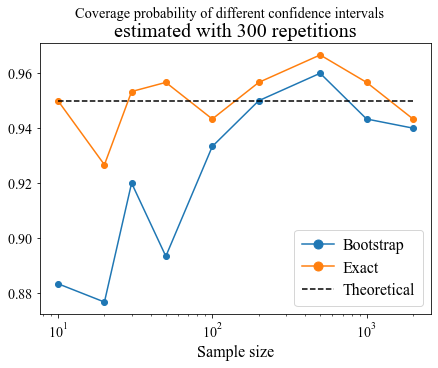

In [23]:
plt.figure(figsize=(7, 5))
plt.plot(sizes, p_cov_boot, '-o', label='Bootstrap')
plt.plot(sizes, p_cov_exact, '-o', label='Exact')
plt.plot(sizes, [0.95] * len(sizes), 'k--', label='Theoretical')
plt.xscale('log')
plt.suptitle(f'Coverage probability of different confidence intervals')
plt.title(f'estimated with {num_repeats} repetitions')
plt.xlabel('Sample size')
plt.legend()
plt.show()

Recommended further reading:
* An Introduction to the Bootstrap B. Efron and R. Tibshirani (1993)
* Bootstrap Methods and Their Application A. Davison, D. Hinkley (1997)

## Delta method

### Exponential growth model

Consider the following growth model:
$$Y_i = a_1 e^{a_2 t_i} + \varepsilon_i, \; \varepsilon_i \sim \mathcal{N}(0, \sigma^2), \; i=1 \dots n,$$
where $t_i$ are points in time. 

In [136]:
true_sigma = 1.0
true_a1 = 1.5
true_a2 = 0.9

t = np.linspace(1, 2, 20)

In [137]:
def f(a1, a2, t):
    return a1 * np.exp(a2 * t)

In [138]:
X = f(true_a1, true_a2, t)
Y = X + np.random.normal(scale=true_sigma, size=len(t))

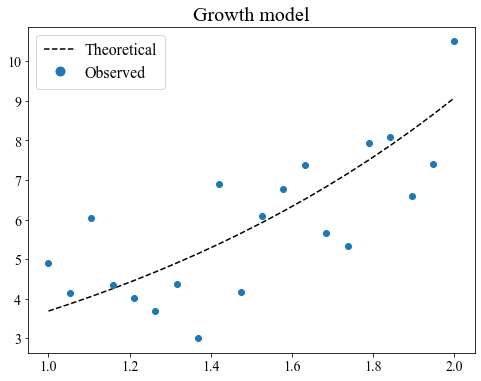

In [139]:
plt.figure(figsize=(8, 6))
plt.title("Growth model")
plt.plot(t, X, 'k--', label='Theoretical')
plt.plot(t, Y, 'o', label='Observed')
plt.legend()

### Estimate the parameters with maximum likelihood

Suppose we want to estimate the values of the parameters $a_1, a_2$ from the data. How can we do it? Observe that in our expression for $Y_i$ the only random part is the noise. This make our observations $Y_i$ **normally distributed**, although with **different means**. Using this we can derive the likelihood function for our sample. If we assume the noise variance is known, the only parameters to estimate are $a_1$ and $a_2$.

$$\mathcal{L}(a_1, a_2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi} \sigma} e^{-\frac{\left(Y_i - a_1 e^{a_2 t}\right)^2}{2 \sigma^2}} = \frac{1}{\left(\sqrt{2\pi} \sigma\right)^n} e^{- \frac{1}{2\sigma^2} \sum_{i=1}^n \left(Y_i - a_1 e^{a_2 t}\right)^2}$$

Log-likelihood for the model is:
$$\ell_n(a_1, a_2) = -\frac{1}{2} \log (2 \pi) - n \log \sigma - \frac{1}{2\sigma^2} \sum_{i=1}^n \left(Y_i - a_1 e^{a_2 t_i}\right)^2$$

Up to some additive and multiplicative constants, the negative log-likelihood can be expressed as: $$nll(a_1, a_2) = \sum_{i=1}^n \left(Y_i - a_1 e^{a_2 t}\right)^2$$

In [189]:
def nll(x, Y, t):
    return ((Y - x[0] * np.exp(x[1] * t)) ** 2).sum()

In [230]:
A1, A2 = np.meshgrid(np.linspace(0, 3, 300), np.linspace(0, 2, 300))
f_nll = np.frompyfunc(lambda a1, a2: nll((a1, a2), Y, t), 2, 1)(A1, A2)

In [231]:
f_nll

array([[753.9617511473198, 751.6093791302801, 749.2610339138354, ...,
        232.3093090435012, 231.15289680319782, 230.0005113634895],
       [753.9617511473198, 751.5845724791791, 749.2115022670649, ...,
        228.53097980707747, 227.3740125787849, 226.22115380651894],
       [753.9617511473198, 751.5594942501074, 749.1614291892577, ...,
        224.74781183652962, 223.5905303390557, 222.4374406779446],
       ...,
       [753.9617511473198, 692.3653532041499, 633.7378403699608, ...,
        112960.14541238992, 113780.30789181408, 114603.43925634722],
       [753.9617511473198, 691.666611024377, 632.4123221009543, ...,
        115915.9604607377, 116756.79812687225, 117600.67664420625],
       [753.9617511473198, 690.9600079345007, 631.0728518405929, ...,
        118947.23541580836, 119809.26604691222, 120674.41126513497]],
      dtype=object)

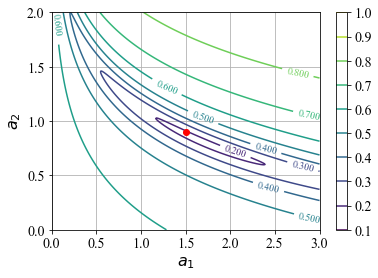

In [232]:
CS = plt.contour(A1, A2, np.log(np.log(np.log(f_nll.astype(float)))))
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()
plt.xlabel("$a_1$")
plt.ylabel("$a_2$")
plt.plot(true_a1, true_a2, 'ro')
plt.colorbar()

In [187]:
mesh[0]

array([[-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
          9.97997998,  10.        ],
       [-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
          9.97997998,  10.        ],
       [-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
          9.97997998,  10.        ],
       ...,
       [-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
          9.97997998,  10.        ],
       [-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
          9.97997998,  10.        ],
       [-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
          9.97997998,  10.        ]])

In [141]:
res = scipy.optimize.minimize(fun=nll, x0=[0, 0], args=(Y, t), method='Nelder-Mead')
print(f"Approximate MLE solution: {res.x}")
a1 = res.x[0]
a2 = res.x[1]

Approximate MLE solution: [1.68729865 0.8095716 ]


### Apply Delta method to estimate standard errors

We have obtained our parameter estimates $\widehat{a}_1, \widehat{a}_2$. We can proceed to use them to make predictions with the model at a new time point: $X(t) = a_1 e^{a_2 t}$. Now, using the Delta method, we can estimate the standard error of $\widehat{X}(t) = \widehat{a}_1 e^{\widehat{a}_2 t} = g_t(\widehat{a}_1, \widehat{a}_2)$:

$$\widehat{se}(\widehat{X}(t)) \approx \sqrt{(\widehat{\nabla} g_t)^T \widehat{J}_n (\widehat{\nabla} g_t)}.$$

Gradient can be estimated by pluging in the estimates of the coefficients to the gradient of $g_t$: $$\widehat{\nabla} g_t = (e^{\widehat{a}_2 t}, \widehat{a}_1 t e^{\widehat{a}_2 t})^T.$$

Matrix $\widehat{J}_n$ is the inverse of the Fisher information matrix, evaluated at the estimates:

$$\widehat{J}_n = J_n(\widehat{a_1}, \widehat{a_2}) = I_n^{-1}(\widehat{a_1}, \widehat{a_2}),$$

$$I_n(a_1, a_2) = - \mathbb{E}_{a_1, a_2}[H].$$

So, to compute our estimates of the standard error, we need find the Hessian of the log-likelihood function.

Gradient of the log-likelihood:
$$\frac{\partial \ell}{\partial a_1} = \frac{1}{\sigma^2} \sum_{i=1}^{n} \left(Y_i - a_1 e^{a_2 t_i}\right) e^{a_2 t_i}$$

$$\frac{\partial \ell}{\partial a_2} = \frac{a_1}{\sigma^2} \sum_{i=1}^{n} \left(Y_i - a_1 e^{a_2 t_i}\right) t_i e^{a_2 t_i}$$

Hessian of the log-likelihood:
$$\frac{\partial^2 \ell}{\partial a_1^2} = - \frac{1}{\sigma^2} \sum_{i=1}^{n} e^{2 a_2 t_i}$$

$$\frac{\partial^2 \ell}{\partial a_2^2} = \frac{a_1}{\sigma^2} \sum_{i=1}^{n} \left(Y_i - 2 a_1 e^{a_2 t_i}\right) t_i^2 e^{a_2 t_i}$$

$$\frac{\partial^2 \ell}{\partial a_1 \partial a_2} = \frac{1}{\sigma^2} \sum_{i=1}^{n} \left(Y_i - 2 a_1 e^{a_2 t_i}\right) t_i e^{a_2 t_i}$$

Definition of the Fisher information requires the expectation **with respect to the distribution defined by the argument**: $I_n(a_1, a_2) = - \mathbb{E}_{a_1, a_2}[H]$. Since the Hessian is linear in $Y_i$ and $\mathbb{E}_{a_1, a_2}[Y_i] = X_i = a_1 e^{a_2 t_i}$. We can just evaluate the Hessian at our estimate:

In [165]:
def ll_hessian(a1, a2, sigma, Y, t):
    H = np.empty((2, 2))
    H[0, 0] = - np.exp(2 * a2 * t).sum()
    H[1, 1] = a1 * ((Y - 2 * a1 * np.exp(a2 * t)) * (t ** 2) * np.exp(a2 * t)).sum()
    H[0, 1] = ((Y - 2 * a1 * np.exp(a2 * t)) * t * np.exp(a2 * t)).sum()
    H[1, 0] = H[0, 1]
    H = H / sigma ** 2
    return H

In [166]:
def grad_g(a1, a2, t):
    return np.array([np.exp(a2 * t), a1 * t * np.exp(a2 * t)])

In [167]:
H = ll_hessian(a1, a2, true_sigma, Y, t)
J = np.linalg.inv(-H)
J

array([[ 0.1443888 , -0.05069051],
       [-0.05069051,  0.01829215]])

### Construct confidence intervals and plot

Now we have our estimates of the parameters $\widehat{a_1}, \widehat{a_2}$ and an estimate of their covariance $\widehat{J}_n$. Let's predict with our model at some previously unseen points:

In [168]:
t_test = np.linspace(0.5, 2.5, 150)

In [169]:
G = grad_g(a1, a2, t_test)

In [170]:
se = np.sqrt((G.T.dot(J)*G.T).sum(axis=1))
se[:5]

array([0.40187831, 0.40175717, 0.40158844, 0.40137121, 0.40110461])

In [171]:
scipy.stats.norm.interval(alpha=0.95)

(-1.959963984540054, 1.959963984540054)

In [172]:
z_l, z_u = scipy.stats.norm.interval(alpha=0.95) 
X_l, X_u = f(a1, a2, t_test) + z_l * se, f(a1, a2, t_test) + z_u * se

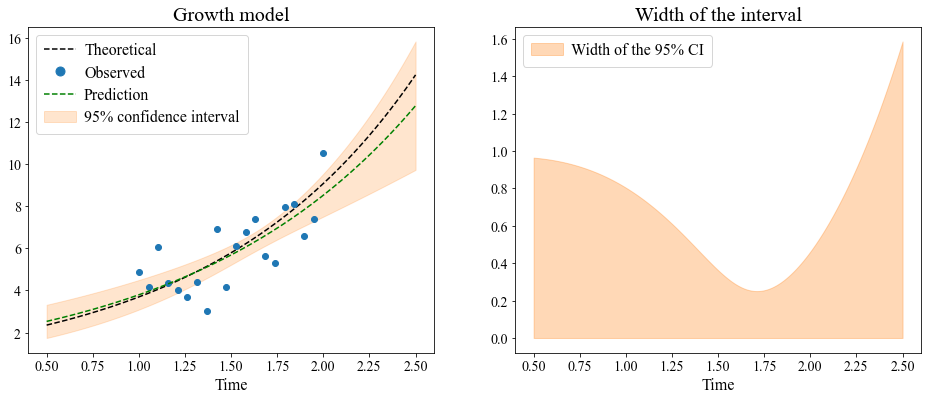

In [173]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax1.set_title("Growth model")

ax1.plot(t_test, f(true_a1, true_a2, t_test), 'k--', label='Theoretical')

ax1.plot(t, Y, 'o', label='Observed')

ax1.plot(t_test, f(a1, a2, t_test), 'g--', label='Prediction')
ax1.fill_between(t_test, X_l, X_u, alpha=0.2, color=cmap(1), label='95% confidence interval')
ax1.set_xlabel("Time")

ax1.legend()

ax2.set_title("Width of the interval")
ax2.fill_between(t_test, X_u - f(true_a1, true_a2, t_test), 0, alpha=0.3, color=cmap(1), label='Width of the 95% CI')
ax2.set_xlabel("Time")
ax2.legend(loc='upper left')

We see that our uncertainty in predictions actually **grows with time**, but also grows slightly to the right, where there were **no observations**. 

Why do the points lie outside the interval? We have obtained our estimates of the true model, so the interval estimates the deviation of the prediction from the true model, not from the future observed noisy data.

### Prediction intervals

What can we do if we actually want to have an interval for future observations? Suppose that new time point is denoted $t_0$.

Recall that our observation model is: 

$$Y_0 = a_1 e^{a_2 t_0} + \varepsilon_0 = X_0 + \varepsilon_0, \; \varepsilon_0 \sim \mathcal{N}(0, \sigma^2)$$

$$\mathbb{E}[Y_0] = a_1 e^{a_2 t_0} = X_0.$$

What should our prediction for the value $Y_0$ be? Lets try $\widehat{X}_0 = \widehat{a}_1 e^{\widehat{a}_2 t_0}$. Since 

$$Y_0 - \widehat{X}_0 = X_0 - \widehat{X}_0 + \varepsilon_0 \approx \mathcal{N}(0, \widehat{se}^2(\widehat{X}_0)) +  \mathcal{N}(0, \sigma^2) = \mathcal{N}(0, \widehat{se}^2(\widehat{X}_0) + \sigma^2),$$

where the approximation if provided by delta method. In turms of computation, it turns out we just need to modify the variance in our normal-based interval: 

$$\widehat{se}(\widehat{Y}_0) = \sqrt{\sigma^2 + (\widehat{\nabla} g_0)^T \widehat{J}_n (\widehat{\nabla} g_0)},$$

where we denote $\widehat{Y}_0 = \widehat{X}_0$ to emphasize the fact that we are trying to estimate $Y_0$.

In [174]:
se_y = np.sqrt((G.T.dot(J)*G.T).sum(axis=1) + true_sigma ** 2)
Y_l, Y_u = f(a1, a2, t_test) + z_l * se_y, f(a1, a2, t_test) + z_u * se_y

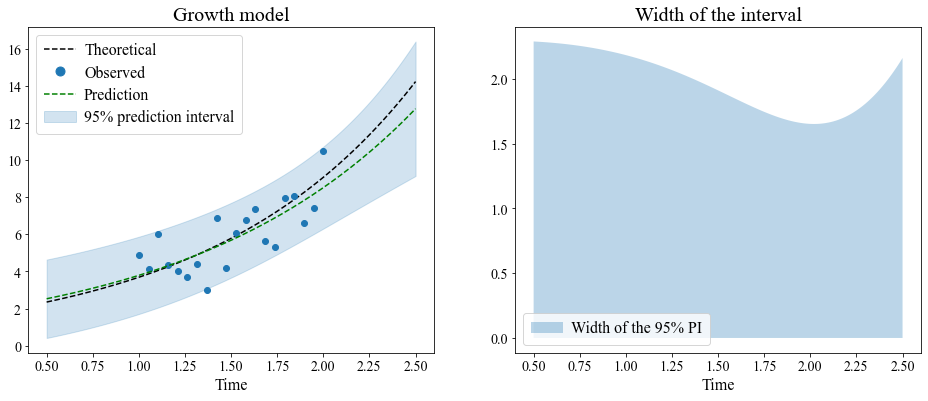

In [175]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax1.set_title("Growth model")

ax1.plot(t_test, f(true_a1, true_a2, t_test), 'k--', label='Theoretical')

ax1.plot(t, Y, 'o', label='Observed')

ax1.plot(t_test, f(a1, a2, t_test), 'g--', label='Prediction')
ax1.fill_between(t_test, Y_l, Y_u, alpha=0.2, color=cmap(0), label='95% prediction interval')
ax1.set_xlabel("Time")

ax1.legend()

ax2.set_title("Width of the interval")
ax2.fill_between(t_test, Y_u - f(true_a1, true_a2, t_test), 0, alpha=0.3, label='Width of the 95% PI')
ax2.set_xlabel("Time")
ax2.legend(loc='lower left')